### Dinámica Secular del sistema

# Descripción

Este notebook carga los archivos de salida generados por `ncorp13` (por ejemplo `ncorp13.dat`, `planet1.dat`, `planet2.dat`, ...) y grafica la evolución temporal de los elementos orbitales: a, e, inc, M, w, O y la longitud del pericentro ϖ = w + O.

Cada elemento se grafica en su propia celda para facilitar la ejecución y la exportación de figuras.

/tmp/ipykernel_8515/3313298926.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None, engine='python')
/tmp/ipykernel_8515/3313298926.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None, engine='python')


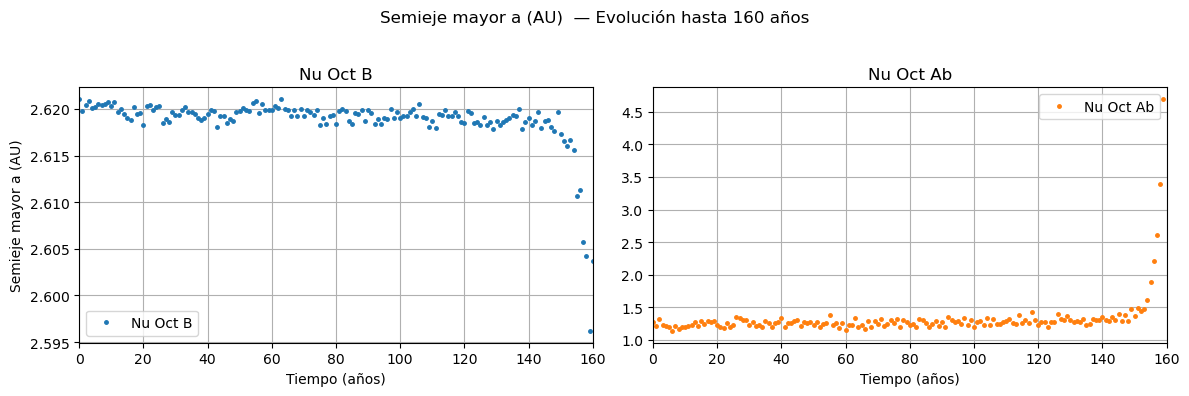

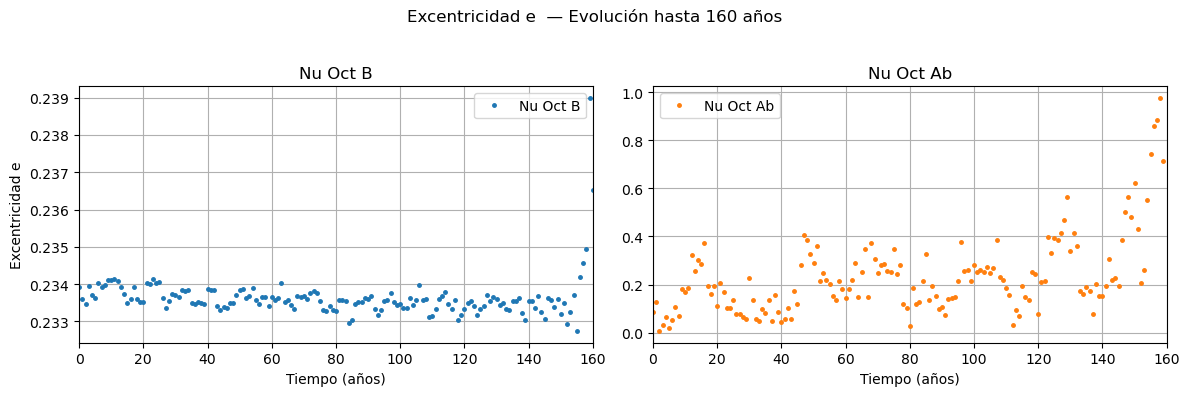

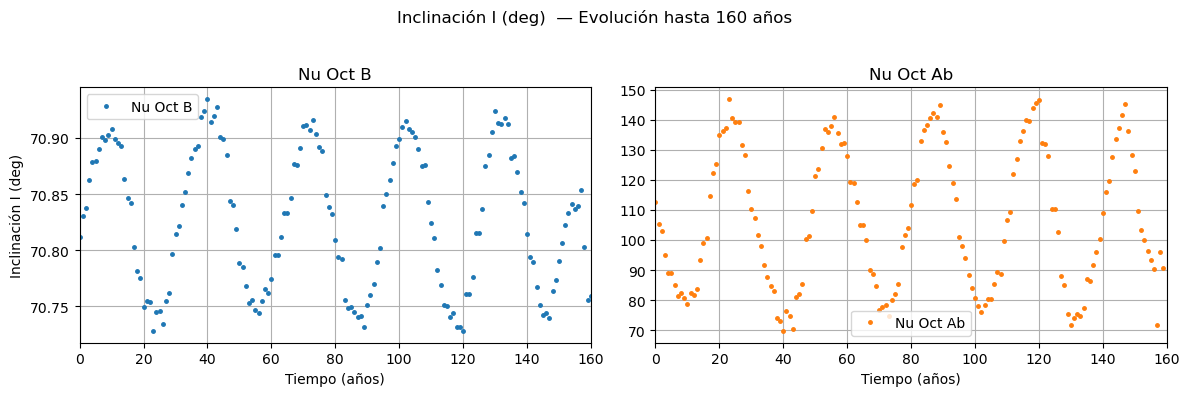

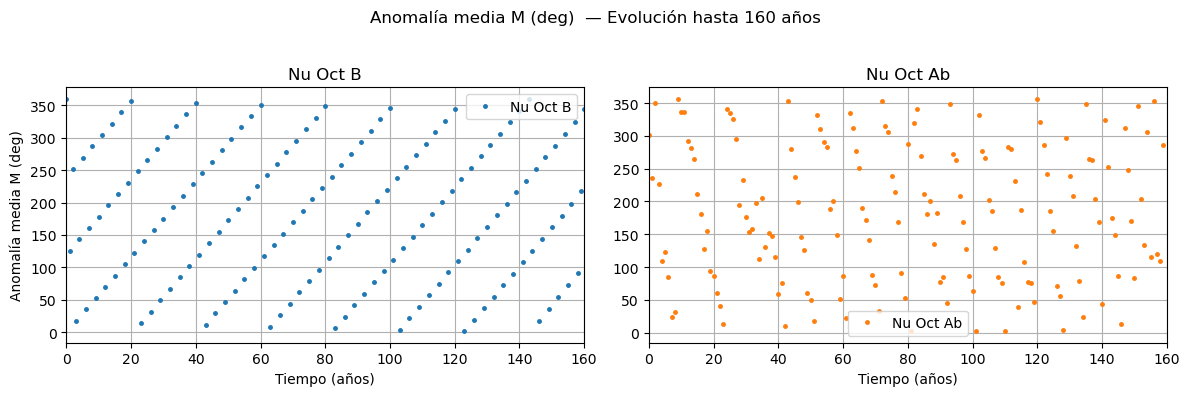

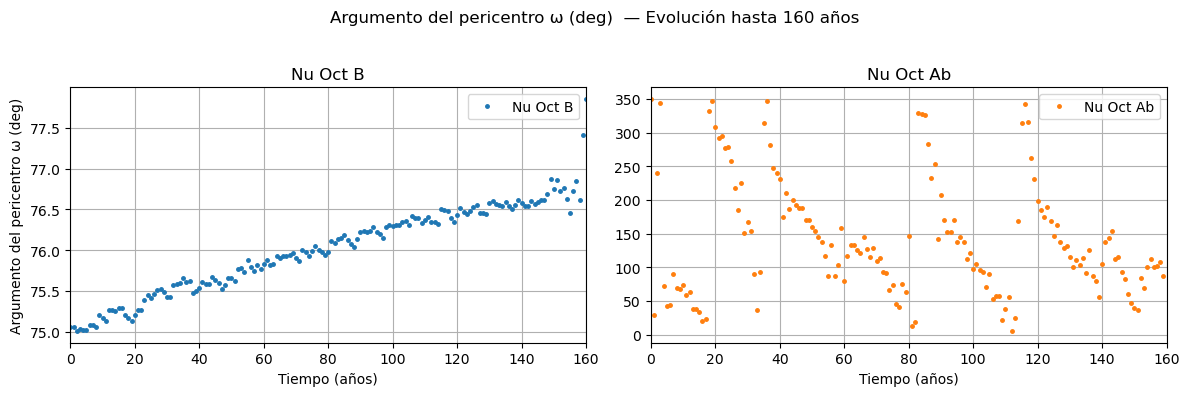

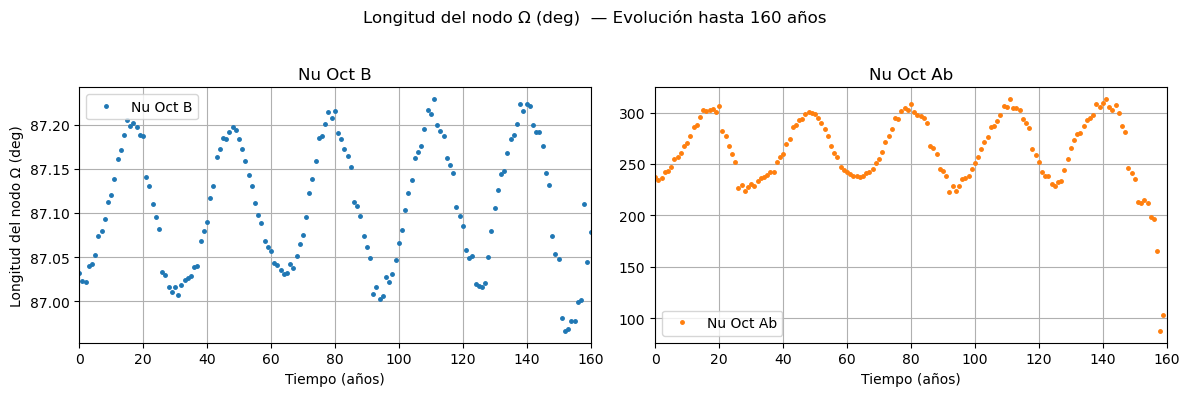

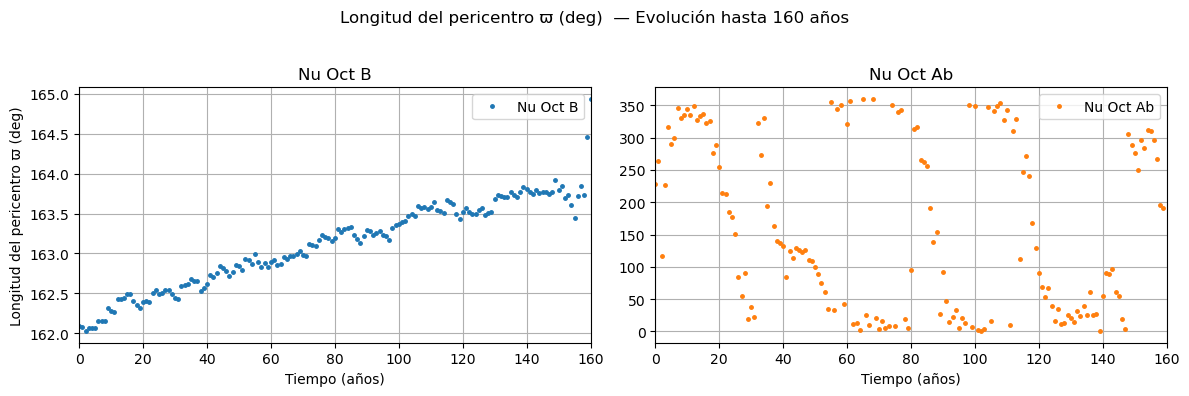

Gráfico guardado: secular_plots/a_secular_plot.png
Gráfico guardado: secular_plots/e_secular_plot.png
Gráfico guardado: secular_plots/inc_secular_plot.png
Gráfico guardado: secular_plots/M_secular_plot.png
Gráfico guardado: secular_plots/w_secular_plot.png
Gráfico guardado: secular_plots/O_secular_plot.png
Gráfico guardado: secular_plots/varpi_secular_plot.png
Todos los gráficos han sido guardados en la carpeta 'secular_plots'.


In [31]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cambie estas variables según sus archivos y los identificadores de cuerpo en su salida NCORP
file_candidate_list = ['ncorp13.dat', 'planets.dat', 'planet1.dat', 'planet2.dat', 'planets.dat']
body_ids = {'secundaria': 2, 'planet': 3}   # usar claves 'secundaria' y 'planet'
max_year = 160  # máximo tiempo a graficar en años

def find_existing_file(candidates):
    for f in candidates:
        if os.path.exists(f):
            return f
    # intentar patrones comunes
    for pattern in ['planet*.dat', 'particles.dat', '*.dat']:
        matches = sorted(glob.glob(pattern))
        if matches:
            return matches[0]
    raise FileNotFoundError("No se encontró archivo de datos. Ajuste file_candidate_list.")

def load_elements(path, body_id=None, max_t=max_year):
    df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None, engine='python')
    ncol = df.shape[1]
    # Detección de formato: con o sin columna de id
    if ncol >= 8:
        # formato con columna i: t, i, a, e, inc, M, w, O, ...
        cols = {'t':0, 'i':1, 'a':2, 'e':3, 'inc':4, 'M':5, 'w':6, 'O':7}
        if body_id is not None:
            df = df[df[cols['i']] == body_id]
    elif ncol >= 7:
        # formato sin columna i (archivos individuales por cuerpo): t, a, e, inc, M, w, O, ...
        cols = {'t':0, 'a':1, 'e':2, 'inc':3, 'M':4, 'w':5, 'O':6}
    else:
        raise ValueError(f"Formato inesperado: {ncol} columnas en {path}")
    # Selección hasta max_t
    df = df[df[cols['t']] <= max_t].copy()
    # Crear dataframe con nombres
    out = pd.DataFrame()
    out['t'] = df.iloc[:, cols['t']].astype(float)
    out['a'] = df.iloc[:, cols['a']].astype(float)
    out['e'] = df.iloc[:, cols['e']].astype(float)
    out['inc'] = df.iloc[:, cols['inc']].astype(float)
    out['M'] = df.iloc[:, cols['M']].astype(float)
    out['w'] = df.iloc[:, cols['w']].astype(float)
    out['O'] = df.iloc[:, cols['O']].astype(float)
    # Longitud del pericentro ϖ = Ω + ω, normalizada a [0,360)
    out['varpi'] = (out['w'] + out['O']) % 360.0
    return out.sort_values('t')

# Cargar datos para cada cuerpo
data_sources = {}
base_file = find_existing_file(file_candidate_list)

for role, bid in body_ids.items():
    # preferir planet1/planet2 si existen
    if role == 'secundaria' and os.path.exists('planet1.dat'):
        path = 'planet1.dat'
    elif role == 'planet' and os.path.exists('planet2.dat'):
        path = 'planet2.dat'
    else:
        path = base_file
    # intentar cargar filtrando por id; si falla, intentar sin id (archivos individuales)
    try:
        data_sources[role] = load_elements(path, body_id=bid, max_t=max_year)
    except Exception:
        try:
            data_sources[role] = load_elements(path, body_id=None, max_t=max_year)
        except Exception as e:
            print(f"No se pudieron cargar datos para {role} desde {path}: {e}")
            data_sources[role] = None

# Elementos a graficar
elements = [
    ('a', 'Semieje mayor a (AU)'),
    ('e', 'Excentricidad e'),
    ('inc', 'Inclinación I (deg)'),
    ('M', 'Anomalía media M (deg)'),
    ('w', 'Argumento del pericentro ω (deg)'),
    ('O', 'Longitud del nodo Ω (deg)'),
    ('varpi', 'Longitud del pericentro ϖ (deg)')
]

# colores y nombres de pantalla
colors = {'secundaria':'C0', 'planet':'C1'}
display_names = {'secundaria': 'Nu Oct B', 'planet': 'Nu Oct Ab'}

plt.rcParams.update({'figure.max_open_warning': 0})

# forzar orden: izquierda=secundaria (planet1), derecha=planet (planet2)
roles = ['secundaria', 'planet']

# Mostrar interactivamente: dos paneles paralelos por elemento (misma X, Y independiente)
for key, ylabel in elements:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharex=True)
    for ax, role in zip(axes, roles):
        name = display_names.get(role, role)
        df = data_sources.get(role)
        if df is None or df.empty:
            ax.text(0.5, 0.5, 'No hay datos para este cuerpo', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(name)
        else:
            ax.plot(df['t'], df[key], marker='.', linestyle='None', markersize=5, label=name, color=colors.get(role, None))
            ax.set_title(name)
            ax.legend(loc='best')
            if ax is axes[0]:
                ax.set_ylabel(ylabel)
        ax.set_xlim(0, max_year)
        ax.grid(True)
        ax.set_xlabel('Tiempo (años)')
    fig.suptitle(f'{ylabel}  — Evolución hasta {max_year} años', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Guardar figuras: dos paneles lado a lado (uno por cuerpo) en la carpeta secular_plots
output_dir = 'secular_plots'
os.makedirs(output_dir, exist_ok=True)
for key, ylabel in elements:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharex=True)
    for ax, role in zip(axes, roles):
        name = display_names.get(role, role)
        df = data_sources.get(role)
        if df is None or df.empty:
            ax.text(0.5, 0.5, 'No hay datos para este cuerpo', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(name)
        else:
            ax.plot(df['t'], df[key], marker='.', linestyle='None', markersize=5, label=name, color=colors.get(role, None))
            ax.set_title(name)
            if ax is axes[0]:
                ax.set_ylabel(ylabel)
            ax.legend(loc='best')
        ax.set_xlim(0, max_year)
        ax.grid(True)
        ax.set_xlabel('Tiempo (años)')
    fig.suptitle(f'{ylabel}  — Evolución hasta {max_year} años', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    output_path = os.path.join(output_dir, f'{key}_secular_plot.png')
    fig.savefig(output_path, dpi=200)
    plt.close(fig)
    print(f'Gráfico guardado: {output_path}')
print(f"Todos los gráficos han sido guardados en la carpeta '{output_dir}'.")


In [6]:
# Acá descargamos los gráficos generados en una carpeta llamada "secular_plots"

output_dir = 'secular_plots'
os.makedirs(output_dir, exist_ok=True)  
for key, ylabel in elements:
    fig, ax = plt.subplots(figsize=(9, 3.5))
    plotted = False
    for role, df in data_sources.items():
        if df is None or df.empty:
            continue
        ax.plot(df['t'], df[key], marker='.', linestyle='None', markersize=5, label=role, color=colors.get(role, None))
        plotted = True
    if not plotted:
        ax.text(0.5, 0.5, 'No hay datos para este elemento', ha='center', va='center', transform=ax.transAxes)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, max_year)
    ax.grid(True)
    ax.legend(loc='best')
    ax.set_xlabel('Tiempo (años)')
    fig.suptitle(f'{ylabel}  — Evolución hasta {max_year} años', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    # Guardar la figura en la carpeta secular_plots
    output_path = os.path.join(output_dir, f'{key}_secular_plot.png')
    fig.savefig(output_path)
    plt.close(fig)
    print(f'Gráfico guardado: {output_path}')
print("Todos los gráficos han sido guardados en la carpeta 'secular_plots'.")








Gráfico guardado: secular_plots/a_secular_plot.png
Gráfico guardado: secular_plots/e_secular_plot.png
Gráfico guardado: secular_plots/inc_secular_plot.png
Gráfico guardado: secular_plots/M_secular_plot.png
Gráfico guardado: secular_plots/w_secular_plot.png
Gráfico guardado: secular_plots/O_secular_plot.png
Gráfico guardado: secular_plots/varpi_secular_plot.png
Todos los gráficos han sido guardados en la carpeta 'secular_plots'.


secundaria | a: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.000390661  P=161
   2: f=0.0248447  A=0.000144709  P=40.25
   3: f=0.0186335  A=0.000140781  P=53.6667
   4: f=0.124224  A=0.000120278  P=8.05
   5: f=0.0621118  A=0.000113141  P=16.1
   6: f=0.118012  A=0.000107761  P=8.47368
   7: f=0.0124224  A=0.000105468  P=80.5
   8: f=0.111801  A=0.000103109  P=8.94444
   9: f=0.0372671  A=9.72424e-05  P=26.8333
  10: f=0.440994  A=9.65963e-05  P=2.26761
  11: f=0.47205  A=8.74467e-05  P=2.11842
  12: f=0.0310559  A=8.2704e-05  P=32.2
  13: f=0.0993789  A=7.8718e-05  P=10.0625
  14: f=0.223602  A=7.25797e-05  P=4.47222
  15: f=0.434783  A=7.15633e-05  P=2.3


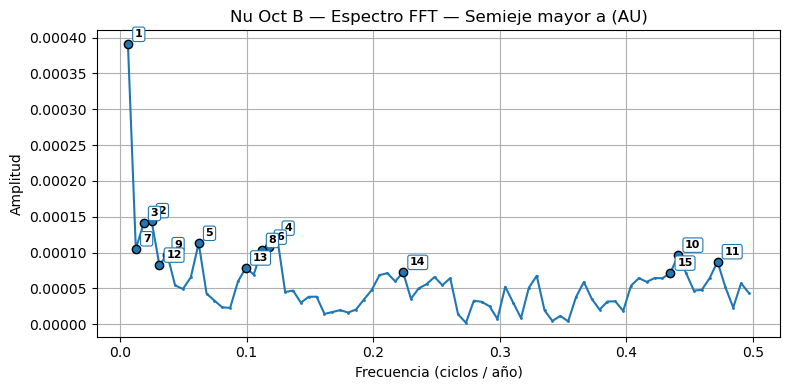

secundaria | e: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=8.33426e-05  P=161
   2: f=0.124224  A=6.37534e-05  P=8.05
   3: f=0.118012  A=4.65874e-05  P=8.47368
   4: f=0.0248447  A=3.7633e-05  P=40.25
   5: f=0.111801  A=3.72004e-05  P=8.94444
   6: f=0.10559  A=3.50951e-05  P=9.47059
   7: f=0.0931677  A=3.09489e-05  P=10.7333
   8: f=0.130435  A=2.99844e-05  P=7.66667
   9: f=0.347826  A=2.95969e-05  P=2.875
  10: f=0.0496894  A=2.79695e-05  P=20.125
  11: f=0.0993789  A=2.78815e-05  P=10.0625
  12: f=0.0559006  A=2.76769e-05  P=17.8889
  13: f=0.204969  A=2.71284e-05  P=4.87879
  14: f=0.223602  A=2.62202e-05  P=4.47222
  15: f=0.0124224  A=2.57942e-05  P=80.5


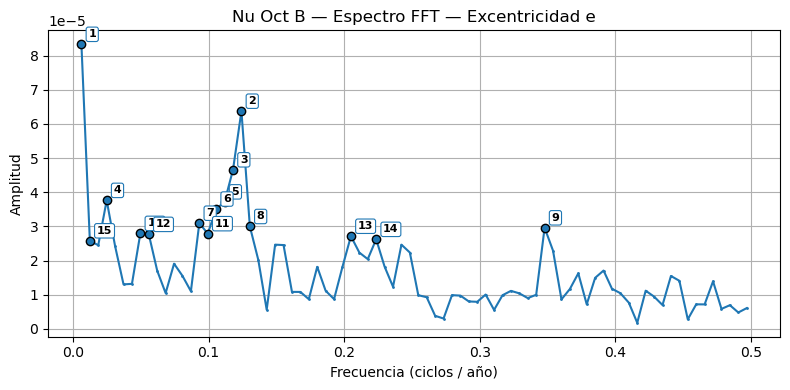

secundaria | inc: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0310559  A=0.000735514  P=32.2
   2: f=0.0372671  A=0.000494317  P=26.8333
   3: f=0.0248447  A=0.000257491  P=40.25
   4: f=0.0434783  A=5.25459e-05  P=23
   5: f=0.00621118  A=4.87469e-05  P=161
   6: f=0.0124224  A=4.72666e-05  P=80.5
   7: f=0.0186335  A=3.78411e-05  P=53.6667
   8: f=0.0745342  A=3.25489e-05  P=13.4167
   9: f=0.068323  A=3.17874e-05  P=14.6364
  10: f=0.335404  A=2.94994e-05  P=2.98148
  11: f=0.329193  A=2.94103e-05  P=3.03774
  12: f=0.31677  A=2.83814e-05  P=3.15686
  13: f=0.0559006  A=2.41742e-05  P=17.8889
  14: f=0.0807453  A=2.02873e-05  P=12.3846
  15: f=0.322981  A=1.955e-05  P=3.09615


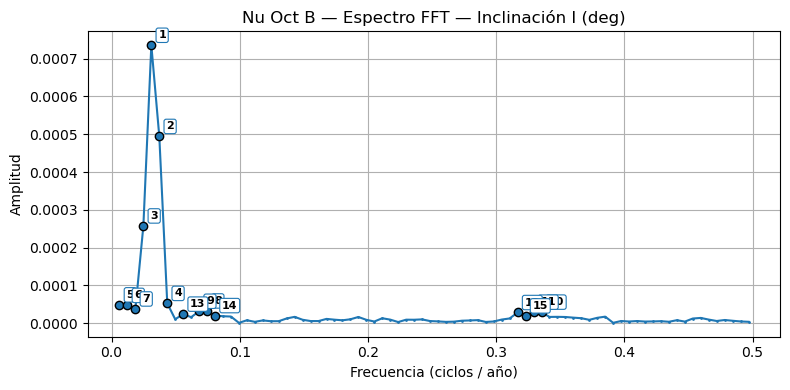

secundaria | M: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=41.7322  P=161
   2: f=0.0124224  A=9.69078  P=80.5
   3: f=0.0186335  A=2.40761  P=53.6667
   4: f=0.0248447  A=0.961247  P=40.25
   5: f=0.0310559  A=0.478761  P=32.2
   6: f=0.0372671  A=0.273102  P=26.8333
   7: f=0.0434783  A=0.170367  P=23
   8: f=0.0496894  A=0.113119  P=20.125
   9: f=0.0559006  A=0.0789461  P=17.8889
  10: f=0.0621118  A=0.0572707  P=16.1
  11: f=0.068323  A=0.042743  P=14.6364
  12: f=0.0745342  A=0.0327195  P=13.4167
  13: f=0.0807453  A=0.0255826  P=12.3846
  14: f=0.0869565  A=0.0202847  P=11.5
  15: f=0.0931677  A=0.0164955  P=10.7333


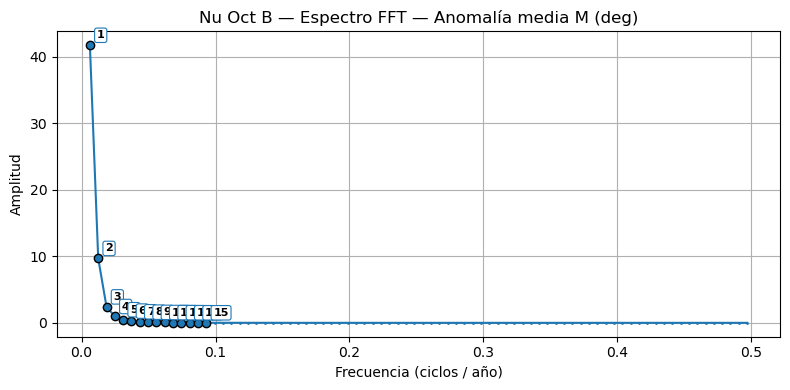

secundaria | w: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.00371331  P=161
   2: f=0.0124224  A=0.00101995  P=80.5
   3: f=0.124224  A=0.000267804  P=8.05
   4: f=0.0993789  A=0.000217979  P=10.0625
   5: f=0.223602  A=0.000206828  P=4.47222
   6: f=0.10559  A=0.000190286  P=9.47059
   7: f=0.0310559  A=0.00017857  P=32.2
   8: f=0.229814  A=0.000176933  P=4.35135
   9: f=0.0186335  A=0.00016907  P=53.6667
  10: f=0.118012  A=0.000163298  P=8.47368
  11: f=0.347826  A=0.000160522  P=2.875
  12: f=0.242236  A=0.000146154  P=4.12821
  13: f=0.130435  A=0.000144385  P=7.66667
  14: f=0.0372671  A=0.000143268  P=26.8333
  15: f=0.354037  A=0.000131284  P=2.82456


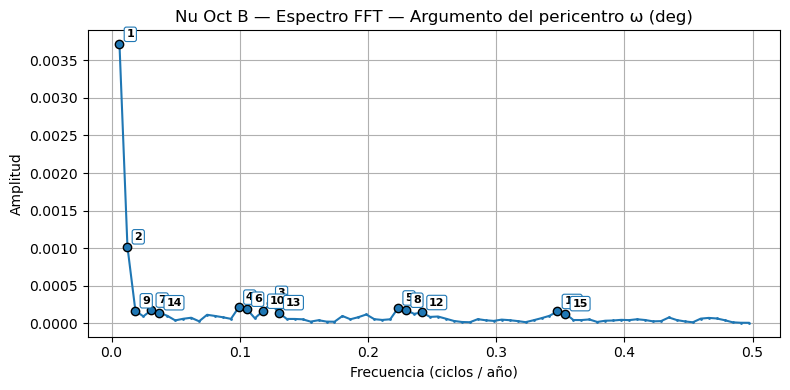

secundaria | O: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0310559  A=0.000782083  P=32.2
   2: f=0.0372671  A=0.000518043  P=26.8333
   3: f=0.0248447  A=0.000304925  P=40.25
   4: f=0.00621118  A=6.89937e-05  P=161
   5: f=0.0434783  A=6.87801e-05  P=23
   6: f=0.0186335  A=5.03272e-05  P=53.6667
   7: f=0.0124224  A=4.24879e-05  P=80.5
   8: f=0.068323  A=3.98366e-05  P=14.6364
   9: f=0.0745342  A=3.689e-05  P=13.4167
  10: f=0.0559006  A=3.55753e-05  P=17.8889
  11: f=0.0621118  A=2.88219e-05  P=16.1
  12: f=0.0931677  A=2.76667e-05  P=10.7333
  13: f=0.335404  A=2.55981e-05  P=2.98148
  14: f=0.0869565  A=2.52061e-05  P=11.5
  15: f=0.329193  A=2.26992e-05  P=3.03774


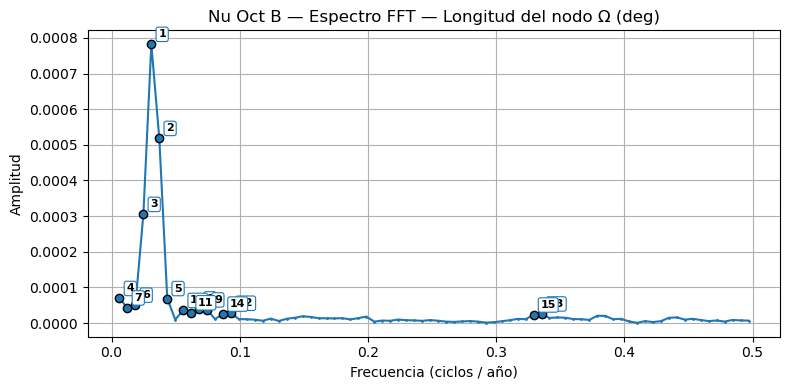

secundaria | varpi: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.00377659  P=161
   2: f=0.0124224  A=0.000978807  P=80.5
   3: f=0.0310559  A=0.00061947  P=32.2
   4: f=0.0372671  A=0.000517317  P=26.8333
   5: f=0.124224  A=0.000265197  P=8.05
   6: f=0.0248447  A=0.000216707  P=40.25
   7: f=0.0186335  A=0.000214204  P=53.6667
   8: f=0.0993789  A=0.000209398  P=10.0625
   9: f=0.223602  A=0.000197407  P=4.47222
  10: f=0.10559  A=0.000196837  P=9.47059
  11: f=0.229814  A=0.000169627  P=4.35135
  12: f=0.0434783  A=0.00016639  P=23
  13: f=0.118012  A=0.00015698  P=8.47368
  14: f=0.347826  A=0.000145136  P=2.875
  15: f=0.242236  A=0.000141721  P=4.12821


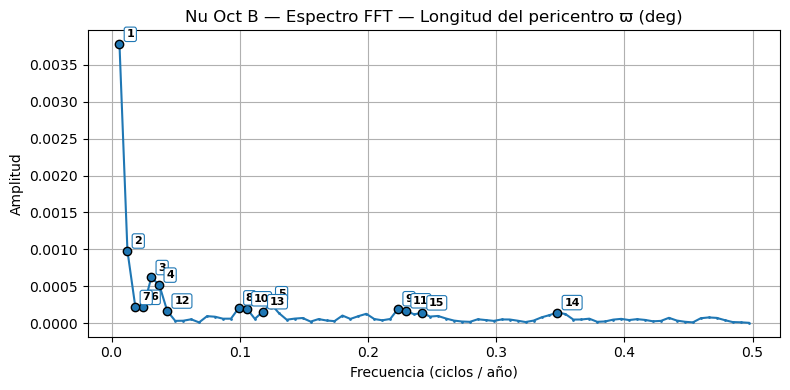

planet | a: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=0.0366092  P=160
   2: f=0.425  A=0.0110475  P=2.35294
   3: f=0.49375  A=0.010232  P=2.02532
   4: f=0.4375  A=0.0101131  P=2.28571
   5: f=0.475  A=0.00939649  P=2.10526
   6: f=0.43125  A=0.00909057  P=2.31884
   7: f=0.41875  A=0.0090374  P=2.38806
   8: f=0.4875  A=0.00872579  P=2.05128
   9: f=0.23125  A=0.00788955  P=4.32432
  10: f=0.25625  A=0.00762513  P=3.90244


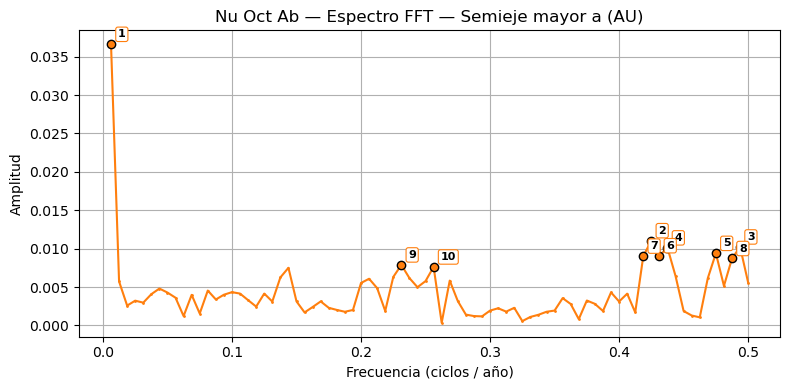

planet | e: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0375  A=0.0358587  P=26.6667
   2: f=0.05  A=0.0190214  P=20
   3: f=0.01875  A=0.0187483  P=53.3333
   4: f=0.0875  A=0.0173523  P=11.4286
   5: f=0.05625  A=0.0166708  P=17.7778
   6: f=0.0125  A=0.0166635  P=80
   7: f=0.03125  A=0.016416  P=32
   8: f=0.1  A=0.014899  P=10
   9: f=0.00625  A=0.014345  P=160
  10: f=0.09375  A=0.0134171  P=10.6667


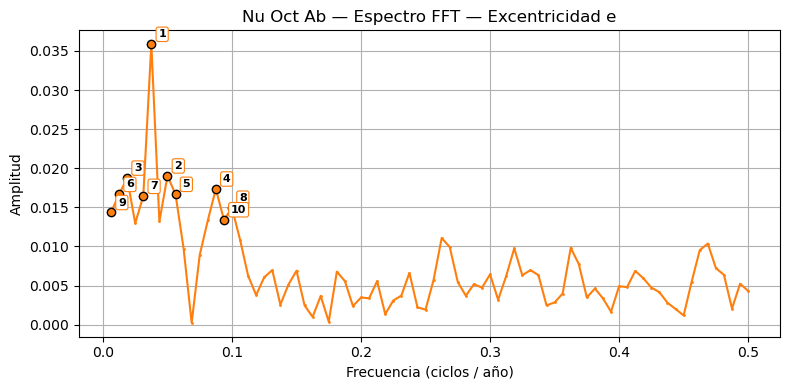

planet | inc: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.03125  A=0.276833  P=32
   2: f=0.0375  A=0.176474  P=26.6667
   3: f=0.025  A=0.103992  P=40
   4: f=0.00625  A=0.0218298  P=160
   5: f=0.0625  A=0.0173974  P=16
   6: f=0.04375  A=0.0168693  P=22.8571
   7: f=0.0125  A=0.0161176  P=80
   8: f=0.05625  A=0.0151262  P=17.7778
   9: f=0.01875  A=0.0140434  P=53.3333
  10: f=0.33125  A=0.0118939  P=3.01887


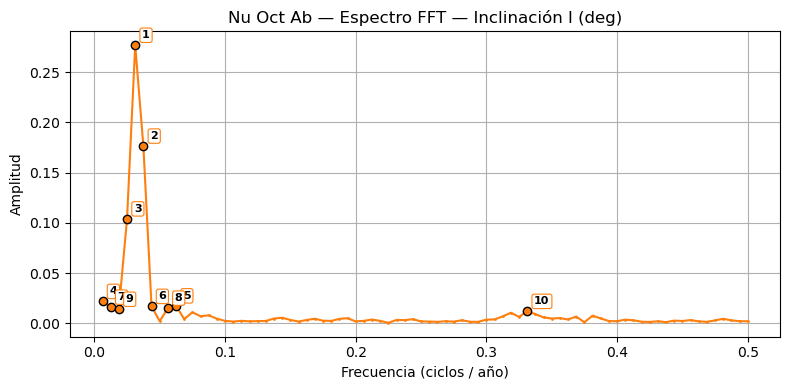

planet | M: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=11.2699  P=160
   2: f=0.0125  A=3.08689  P=80
   3: f=0.0375  A=0.425509  P=26.6667
   4: f=0.01875  A=0.402042  P=53.3333
   5: f=0.03125  A=0.385294  P=32
   6: f=0.025  A=0.367542  P=40
   7: f=0.0625  A=0.240484  P=16
   8: f=0.05  A=0.172599  P=20
   9: f=0.06875  A=0.14154  P=14.5455
  10: f=0.04375  A=0.141273  P=22.8571


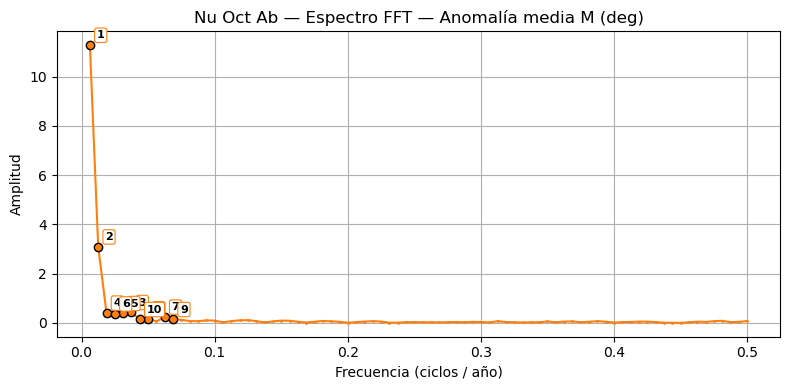

planet | w: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=2.67237  P=160
   2: f=0.0125  A=0.851793  P=80
   3: f=0.01875  A=0.806866  P=53.3333
   4: f=0.025  A=0.472353  P=40
   5: f=0.05625  A=0.26611  P=17.7778
   6: f=0.04375  A=0.176982  P=22.8571
   7: f=0.03125  A=0.175243  P=32
   8: f=0.0625  A=0.161674  P=16
   9: f=0.05  A=0.145384  P=20
  10: f=0.08125  A=0.132763  P=12.3077


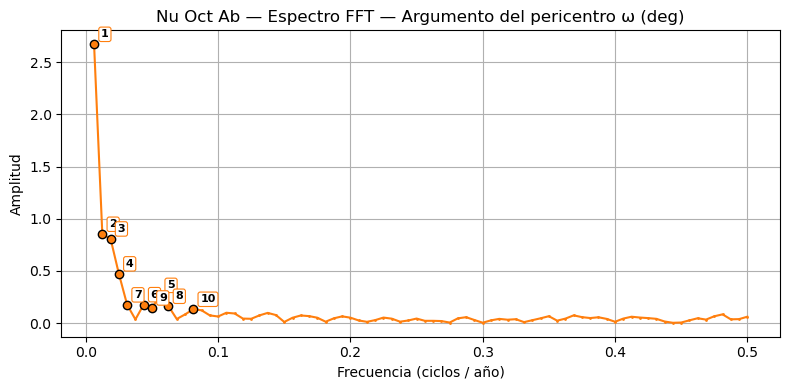

planet | O: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.03125  A=0.311641  P=32
   2: f=0.0375  A=0.193279  P=26.6667
   3: f=0.025  A=0.128473  P=40
   4: f=0.00625  A=0.0411481  P=160
   5: f=0.0625  A=0.0328862  P=16
   6: f=0.04375  A=0.0256213  P=22.8571
   7: f=0.01875  A=0.0193376  P=53.3333
   8: f=0.05625  A=0.018402  P=17.7778
   9: f=0.0125  A=0.0163458  P=80
  10: f=0.075  A=0.0144585  P=13.3333


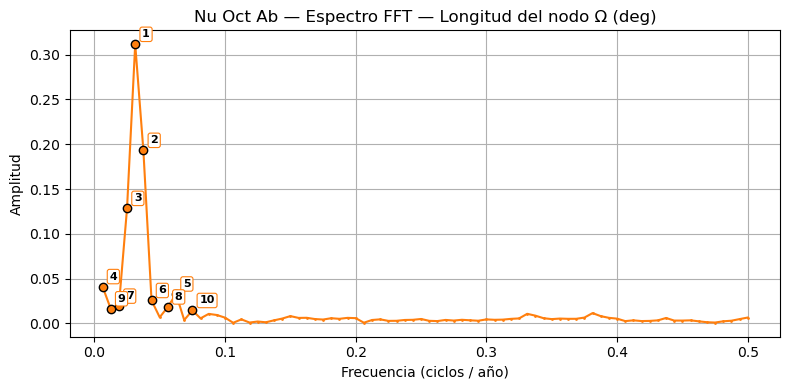

planet | varpi: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=2.63815  P=160
   2: f=0.0125  A=0.867999  P=80
   3: f=0.01875  A=0.818804  P=53.3333
   4: f=0.025  A=0.580729  P=40
   5: f=0.03125  A=0.404271  P=32
   6: f=0.05625  A=0.283026  P=17.7778
   7: f=0.0625  A=0.193416  P=16
   8: f=0.0375  A=0.163179  P=26.6667
   9: f=0.04375  A=0.157914  P=22.8571
  10: f=0.05  A=0.152098  P=20


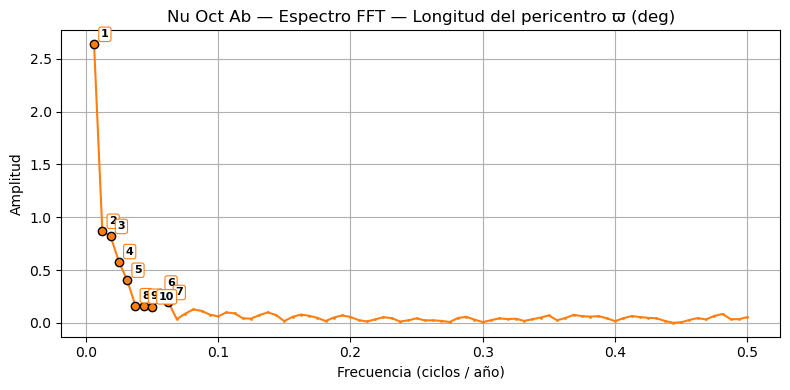

Gráfico FFT (con top15) guardado: secular_fft_plots/secundaria_a_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secundaria_a_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secundaria_e_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secundaria_e_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secundaria_inc_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secundaria_inc_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secundaria_M_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secundaria_M_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secundaria_w_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secundaria_w_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secundaria_O_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secundaria_O_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secundaria_varpi_fft_top15.png
Tabla top15 guardada: secular_fft_plo

In [33]:
import numpy as np

def compute_and_plot_fft(data_sources, elements, max_year=None, markersize=2, top_n=10, marker_peak_size=6):
    angle_keys = {'M','w','O','varpi','inc'}
    for role, df in data_sources.items():
        if df is None or df.empty:
            print(f"No hay datos para {role}")
            continue

        role_l = role.lower()
        # color por rol: planet -> naranja, secundaria -> azul
        role_color = 'C1' if 'planet' in role_l else 'C0'
        # top por rol: secundaria -> 15, planeta -> 10, fallback a top_n
        if 'secundaria' in role_l:
            role_top_n = 15
        elif 'planet' in role_l:
            role_top_n = 10
        else:
            role_top_n = top_n

        for key, ylabel in elements:
            t = df['t'].values
            if max_year is not None:
                mask = t <= max_year
                t = t[mask]
                y = df[key].values[mask]
            else:
                y = df[key].values

            if len(t) < 4:
                print(f"{role} — {key}: datos insuficientes")
                continue

            if key in angle_keys:
                y_rad = np.deg2rad(y.astype(float))
                y_proc = np.unwrap(y_rad)
            else:
                y_proc = y.astype(float)

            dt = np.median(np.diff(t))
            if dt <= 0:
                print(f"{role} — {key}: dt no válido")
                continue
            t_uniform = np.arange(t[0], t[-1] + 0.5*dt, dt)
            y_uniform = np.interp(t_uniform, t, y_proc)

            y_uniform = y_uniform - np.mean(y_uniform)
            window = np.hanning(len(y_uniform))
            y_win = y_uniform * window

            N = len(y_win)
            yf = np.fft.rfft(y_win)
            freq = np.fft.rfftfreq(N, d=dt)
            amp = np.abs(yf) * 2.0 / N

            valid = freq > 0
            freq_v = freq[valid]
            amp_v = amp[valid]

            fig, ax = plt.subplots(figsize=(8,4))
            ax.plot(freq_v, amp_v, marker='.', linestyle='-', markersize=markersize, color=role_color, label=display_names.get(role, role))
            ax.set_xlabel('Frecuencia (ciclos / año)')
            ax.set_ylabel('Amplitud')
            ax.set_title(f"{display_names.get(role, role)} — Espectro FFT — {ylabel}")
            ax.grid(True)

            if len(amp_v) > 0:
                idx = np.argsort(amp_v)[-role_top_n:][::-1]
                peaks = [(freq_v[i], amp_v[i]) for i in idx]
                print(f"{role} | {key}: top {role_top_n} frecuencias (ciclos/año), amplitud, periodo (años):")
                for rank, (fval, aval) in enumerate(peaks, start=1):
                    per = (1.0/fval if fval>0 else np.inf)
                    print(f"  {rank:2d}: f={fval:.6g}  A={aval:.6g}  P={per:.6g}")
                    ax.plot(fval, aval, marker='o', color=role_color, markersize=marker_peak_size, markeredgecolor='k')
                    ax.annotate(str(rank), xy=(fval, aval), xytext=(5,5), textcoords='offset points',
                                fontsize=8, fontweight='bold', color='k',
                                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=role_color, lw=0.8))
            plt.tight_layout()
            plt.show()

# Ejecutar análisis FFT por cuerpo y por elemento
compute_and_plot_fft(data_sources, elements, max_year=max_year, markersize=2, top_n=10, marker_peak_size=6)

# Guardar FFT plots + tablas
output_dir_fft = 'secular_fft_plots'
os.makedirs(output_dir_fft, exist_ok=True)
top_n = 10
markersize = 2
marker_peak_size = 6
angle_keys = {'M', 'w', 'O', 'varpi', 'inc'}

for role, df in data_sources.items():
    if df is None or df.empty:
        print(f"No hay datos para {role}")
        continue

    role_l = role.lower()
    role_color = 'C1' if 'planet' in role_l else 'C0'
    if 'secundaria' in role_l:
        role_top_n = 15
    elif 'planet' in role_l:
        role_top_n = 10
    else:
        role_top_n = top_n

    for key, ylabel in elements:
        t = df['t'].values
        if max_year is not None:
            mask = t <= max_year
            t = t[mask]
            y = df[key].values[mask]
        else:
            y = df[key].values

        if len(t) < 4:
            print(f"{role} — {key}: datos insuficientes")
            continue

        if key in angle_keys:
            y_rad = np.deg2rad(y.astype(float))
            y_proc = np.unwrap(y_rad)
        else:
            y_proc = y.astype(float)

        dt = np.median(np.diff(t))
        if dt <= 0:
            print(f"{role} — {key}: dt no válido")
            continue
        t_uniform = np.arange(t[0], t[-1] + 0.5*dt, dt)
        y_uniform = np.interp(t_uniform, t, y_proc)

        y_uniform = y_uniform - np.mean(y_uniform)
        window = np.hanning(len(y_uniform))
        y_win = y_uniform * window

        N = len(y_win)
        yf = np.fft.rfft(y_win)
        freq = np.fft.rfftfreq(N, d=dt)
        amp = np.abs(yf) * 2.0 / N

        valid = freq > 0
        freq_v = freq[valid]
        amp_v = amp[valid]

        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(freq_v, amp_v, marker='.', linestyle='-', markersize=markersize, color=role_color, label=display_names.get(role, role))
        ax.set_xlabel('Frecuencia (ciclos / año)')
        ax.set_ylabel('Amplitud')
        ax.set_title(f"{display_names.get(role, role)} — Espectro FFT — {ylabel}")
        ax.grid(True)

        peaks_info = []
        if len(amp_v) > 0:
            idx = np.argsort(amp_v)[-role_top_n:][::-1]
            for rank, i in enumerate(idx, start=1):
                fval = float(freq_v[i])
                aval = float(amp_v[i])
                per = (1.0/fval if fval>0 else np.inf)
                peaks_info.append({'rank': rank, 'frequency_cpyear': fval, 'amplitude': aval, 'period_years': per})
                ax.plot(fval, aval, marker='o', color=role_color, markersize=marker_peak_size, markeredgecolor='k')
                ax.annotate(str(rank), xy=(fval, aval), xytext=(5,5), textcoords='offset points',
                            fontsize=8, fontweight='bold', color='k',
                            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=role_color, lw=0.8))

        ax.legend()
        plt.tight_layout()
        out_png = os.path.join(output_dir_fft, f'{role}_{key}_fft_top{role_top_n}.png')
        fig.savefig(out_png, dpi=200)
        plt.close(fig)
        print(f'Gráfico FFT (con top{role_top_n}) guardado: {out_png}')

        if peaks_info:
            df_peaks = pd.DataFrame(peaks_info)
            out_csv = os.path.join(output_dir_fft, f'{role}_{key}_fft_top{role_top_n}.csv')
            df_peaks.to_csv(out_csv, index=False, float_format='%.6g')
            print(f'Tabla top{role_top_n} guardada: {out_csv}')

print("Todos los gráficos FFT (con tops) han sido guardados en la carpeta 'secular_fft_plots'.")
# ...existing code...